In [9]:
## Checking the GPU configuration
import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)
!nvidia-smi

Sun Jun 27 06:16:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  RTX A6000           Off  | 00000000:1B:00.0 Off |                  Off |
| 30%   35C    P8    18W / 300W |  47151MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
from skimage.transform import resize
from imageio import imread

In [11]:
# Importing the necessary libraries

import numpy as np
import os

import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [12]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
#import tensorflow as tf

tf.random.set_seed(30)

In [10]:
#!pip install keras

In [13]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [15]:
project_folder='./datasets/Project_data'

In [16]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
#### This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [15]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=16,batch_size=8,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# Model
#### Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [16]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 80, 80, 32)     1

In [36]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
83/83 [==============================] - ETA: 0s - loss: 1.5826 - categorical_accuracy: 0.3741
Epoch 00001: val_loss improved from inf to 5.41746, saving model to model_init_2021-06-2620_25_16.075581/model-00001-1.58260-0.37406-5.41746-0.19000.h5
83/83 [==============================] - 92s 1s/step - loss: 1.5826 - categorical_accuracy: 0.3741 - val_loss: 5.4175 - val_categorical_accuracy: 0.1900


#### Sample Cropping


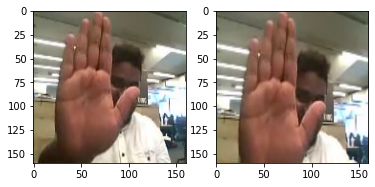

In [18]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   
plt.show()

## Lets play with image size n frame rates

In [38]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_9 (Activation)    (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 50, 50, 32)    

In [39]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=16,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 30, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 30, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 15, 50, 50, 32)    4128      
_________________________________________________________________
activation_13 (Activation)   (None, 15, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 15, 50, 50, 32)   

In [40]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_17 (Activation)   (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 15, 80, 80, 32)   

In [42]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_24 (Activation)   (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_25 (Activation)   (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 15, 80, 80, 32)   

## Observation
- Image resolution  and number of frames have more impact on training time than batch_size
- We can consider the Batch Size around 15-40
- We will consider resolution as 160x160

In [43]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()
print("Total Params:", conv_3d1_model.count_params())
history_model1final = conv_3d1.train_model(conv_3d1_model)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_28 (Activation)   (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_29 (Activation)   (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 15, 80, 80, 32)   

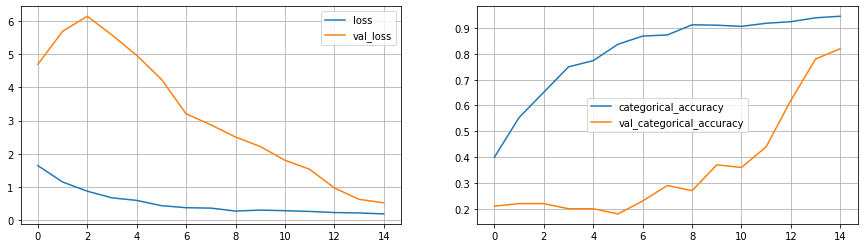

In [44]:
plot(history_model1final)

In [45]:
## Accuracy is has started improving post epoch 10
## Lets try by adding drop out layers

In [19]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:

conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=15)
conv_3d1_model=conv_3d1.define_model(dense_neurons=256,dropout=0.5)
conv_3d1_model.summary()
print("Total Params:", conv_3d1_model.count_params())
history_model1dropout = conv_3d1.train_model(conv_3d1_model)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
activation_5 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 80, 80, 32)   

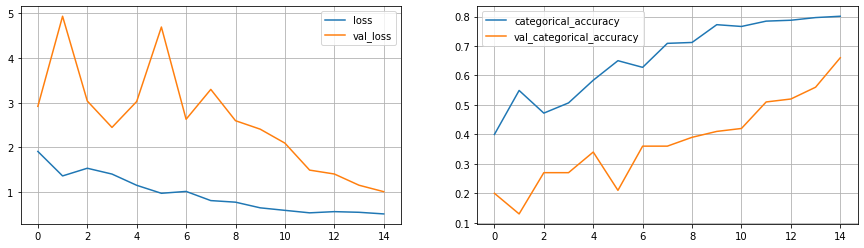

In [21]:
plot(history_model1dropout)

#### cat accuracy has reached to 0.80 n val cat accuracy is 0.66, although model is learning incremently but it has made slow progress

## Model 3 
### Reduce filter size to (2,2,2) and image res to 120 x  120, - Batch Size = 30 and No. of Epochs = 25

In [24]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_8 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_9 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 60, 60, 32)    

In [26]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.9885 - categorical_accuracy: 0.3590
Epoch 00001: val_loss improved from inf to 1.89696, saving model to model_init_2021-06-2622_39_04.188783/model-00001-1.98845-0.35897-1.89696-0.16000.h5
23/23 [==============================] - 140s 6s/step - loss: 1.9885 - categorical_accuracy: 0.3590 - val_loss: 1.8970 - val_categorical_accuracy: 0.1600
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.4517 - categorical_accuracy: 0.5023
Epoch 00002: val_loss did not improve from 1.89696
23/23 [==============================] - 140s 6s/step - loss: 1.4517 - categorical_accuracy: 0.5023 - val_loss: 2.5923 - val_categorical_accuracy: 0.1300
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.2431 - categorical_accuracy: 0.5528
Epoch 00003: val_loss did not improve from 1.89696
23/23 [==============================] - 142s 6s/step - loss: 1.2431 - categorical_accuracy: 0.552

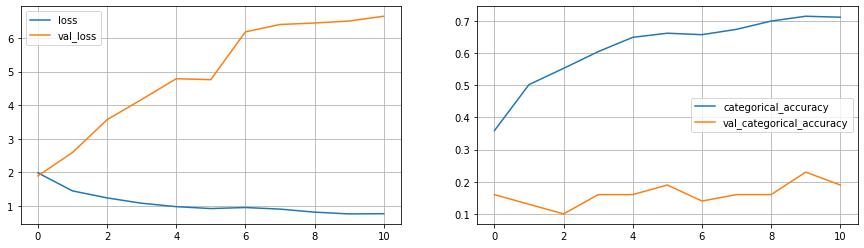

In [27]:
plot(history_model3)

##### Model has a  best validation accuracy of 23% and training accuracy of 76% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers
- Lets add more layers with drop outs


In [32]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_13 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 8, 60, 60, 16)    

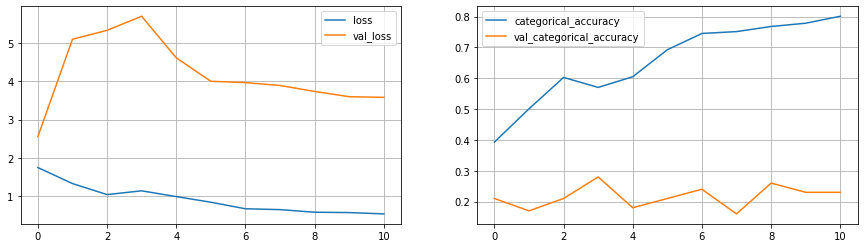

In [34]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d4_model.summary()

print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)
plot(history_model4)

### Overfitting
### Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.

### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance


In [35]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_20 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 8, 50, 50, 32)     13856     
_________________________________________________________________
activation_21 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 8, 50, 50, 32)    

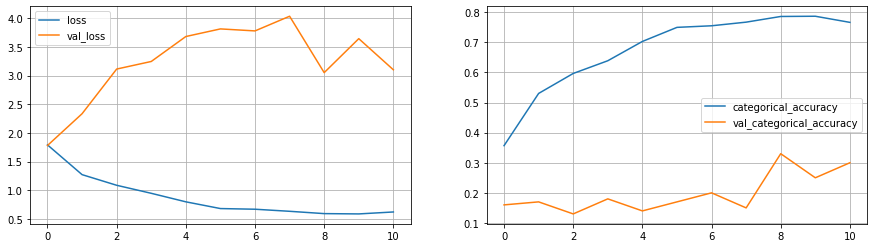

In [36]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=100,image_width=100)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d5_model=conv_3d5.define_model(dense_neurons=64,dropout=0.25)
conv_3d5_model.summary()

print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)
plot(history_model5)

### Model - CNN- LSTM Model

In [15]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=30)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 30, 30, 64)   

In [18]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.3208 - categorical_accuracy: 0.4291
Epoch 00001: val_loss improved from inf to 2.10990, saving model to model_init_2021-06-2617_46_38.959805/model-00001-1.32082-0.42911-2.10990-0.19000.h5
83/83 [==============================] - 151s 2s/step - loss: 1.3208 - categorical_accuracy: 0.4291 - val_loss: 2.1099 - val_categorical_accuracy: 0.1900
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.1788 - categorical_accuracy: 0.4985
Epoch 00002: val_loss did not improve from 2.10990
83/83 [==============================] - 150s 2s/step - loss: 1.1788 - categorical_accuracy: 0.4985 - val_loss: 2.6506 - val_categorical_accuracy: 0.2400
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.0334 - categorical_accuracy: 0.5913
Epoch 00003: val_loss improved from 2.10990 to 1.43241, saving model to model_init_2021-06-2617_46_38.959805/model-00003-1.03339-0.59125-1.43241-0.39

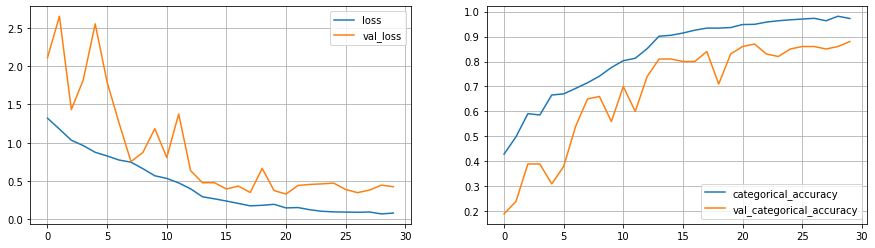

In [19]:
plot(history_model)

## Loading model and Testing


In [20]:
import time
from keras.models import load_model
model = load_model('model_init_2021-06-2617_46_38.959805/model-00021-0.15074-0.94796-0.33161-0.86000.h5')


In [21]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=8,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [22]:
batch_labels

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [23]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[0 1 4 0 4 2 2 3]


####  Transfer Learning with GRU and training all weights

In [5]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
# in the nimblebox.ai platform. 
import abc

from keras.applications import mobilenet

In [19]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

In [20]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [22]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model7=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 0.8979 - categorical_accuracy: 0.6697
Epoch 00001: saving model to model_init_2021-06-2706_19_32.293668/model-00001-0.89789-0.66968-0.28749-0.93000.h5
133/133 [==============================] - 149s 1s/step - loss: 0.8979 - categorical_accuracy: 0.6697 - val_loss: 0.2875 - val_categorical_accuracy: 0.9300
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.3158 - categorical_accuracy: 0.9035
Epoch 00002: saving model to model_init_2021-06-2706_19_32.293668/model-00002-0.31578-0.90347-0.20134-0.96000.h5
133/133 [==============================] - 147s 1s/step - loss: 0.3158 - categorical_accuracy: 0.9035 - val_loss: 0.2013 - val_categorical_accuracy: 0.9600
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.2247 - categorical_accuracy: 0.9359
Epoch 00003: saving model to model_init_2021-06-2706_19_32.293668/model-00003-0.22468-0.93590-0.18731-0.93000.h5
133

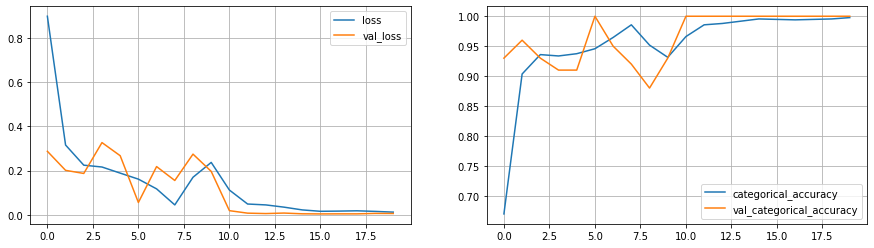

In [23]:
plot(history_model7)